# Doppler shifts via Fourier Transforms

In [1]:
%matplotlib inline

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import dblquad
import mpmath

In [4]:
def _hyp2f1(a, b, c, z):
    """
    The Hypergeometric function 2F1 for 
    complex-valued arguments.
    
    """
    res = mpmath.hyp2f1(a, b, c, z)
    return float(res.real) + float(res.imag) * 1j

# Vectorize it
hyp2f1 = np.vectorize(_hyp2f1)

In [5]:
def I_num(xi, I0, alpha=0):
    """
    Return the shifted spectrum, computed numerically.
    
    """
    xi0 = xi - alpha
    return np.interp(xi0, xi, I0)

In [6]:
def S_num(xi, I0, alpha=0, npts=1000):
    """
    Return the disk-integrated spectrum, computed numerically.
    
    """
    S = np.zeros_like(xi)
    A = 0
    beta = np.exp(alpha) - 1
    for x in np.linspace(-1, 1, npts + 2)[1:-1]:
        beta_x = beta * x
        alpha_x = np.log(1 + beta_x)
        S += I_num(xi, I0, alpha=alpha_x) * np.sqrt(1 - x ** 2)
        A += np.sqrt(1 - x ** 2)
    return S / A

In [7]:
def I(xi, I0, alpha=0):
    """
    Return the shifted spectrum, computed via an FFT.
    
    """
    # Number of wavelength bins
    N = len(xi)
    
    # Take the FFT
    fI0 = np.fft.rfft(I0)
    f = np.fft.rfftfreq(N, xi[1] - xi[0])
    
    # Apply the translation
    fI0 *= np.exp(-2 * np.pi * alpha * 1j * f)
    
    # Take the inverse FFT and return
    return np.fft.irfft(fI0, N)

In [8]:
def S(xi, I0, alpha=0, npts=1000):
    """
    Return the disk-integrated spectrum, computed via an FFT.
    
    """
    # Number of wavelength bins
    N = len(xi)
    
    # Take the FFT
    fI0 = np.fft.rfft(I0)
    f = np.fft.rfftfreq(N, xi[1] - xi[0])
    
    # Apply the integral of the translation    
    fI0 *= hyp2f1(f * np.pi * 1j, 0.5 + f * np.pi * 1j, 2, beta ** 2)
    
    # Take the inverse FFT and return
    return np.fft.irfft(fI0, N)

## Plot the shifted spectrum

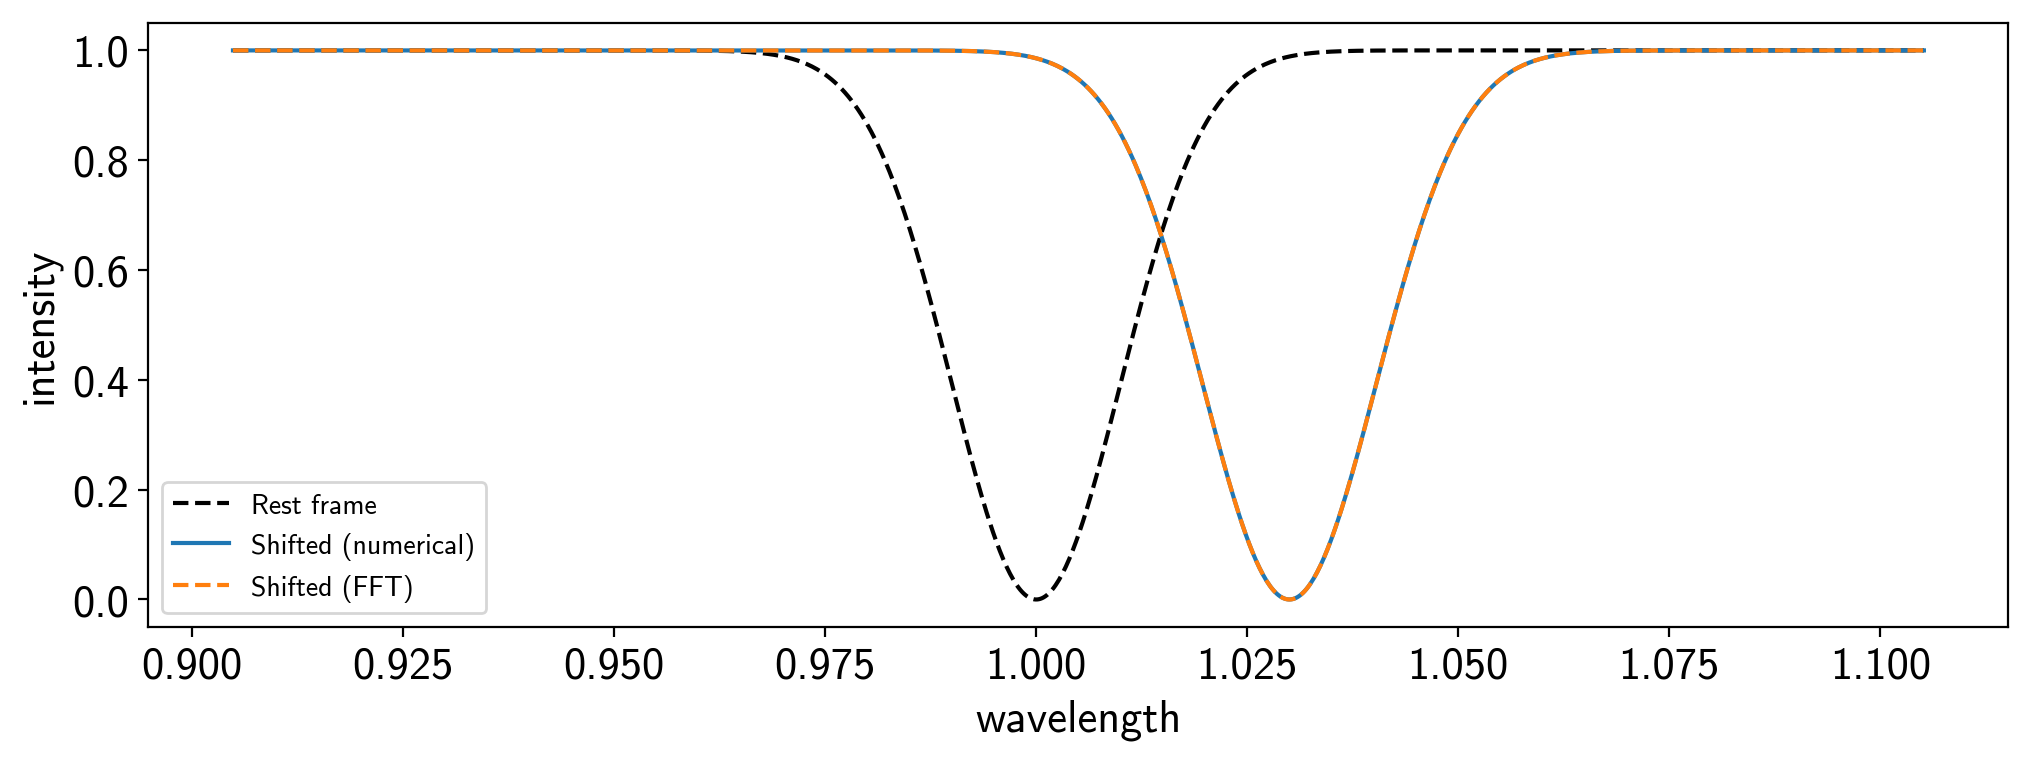

In [9]:
# An evenly sampled timeseries in xi = log(wavelength)
xi = np.linspace(-0.1, 0.1, 1000)
lam = np.exp(xi)

# A gaussian absorption line
amp = 1.0
mu = 1.0
sigma = 0.01
I0 = 1 - amp * np.exp(-0.5 * (lam - mu) ** 2 / sigma ** 2)

# A moderate doppler shift
beta = -0.03
alpha = np.log(1 - beta)

# Plot the shifted line
plt.plot(lam, I0, 'k--', label="Rest frame")
plt.plot(lam, I_num(xi, I0, alpha=alpha), 'C0', label="Shifted (numerical)")
plt.plot(lam, I(xi, I0, alpha=alpha), 'C1--', label="Shifted (FFT)")
plt.legend(fontsize=10)
plt.xlabel("wavelength")
plt.ylabel("intensity");

## Plot the disk-integrated spectrum

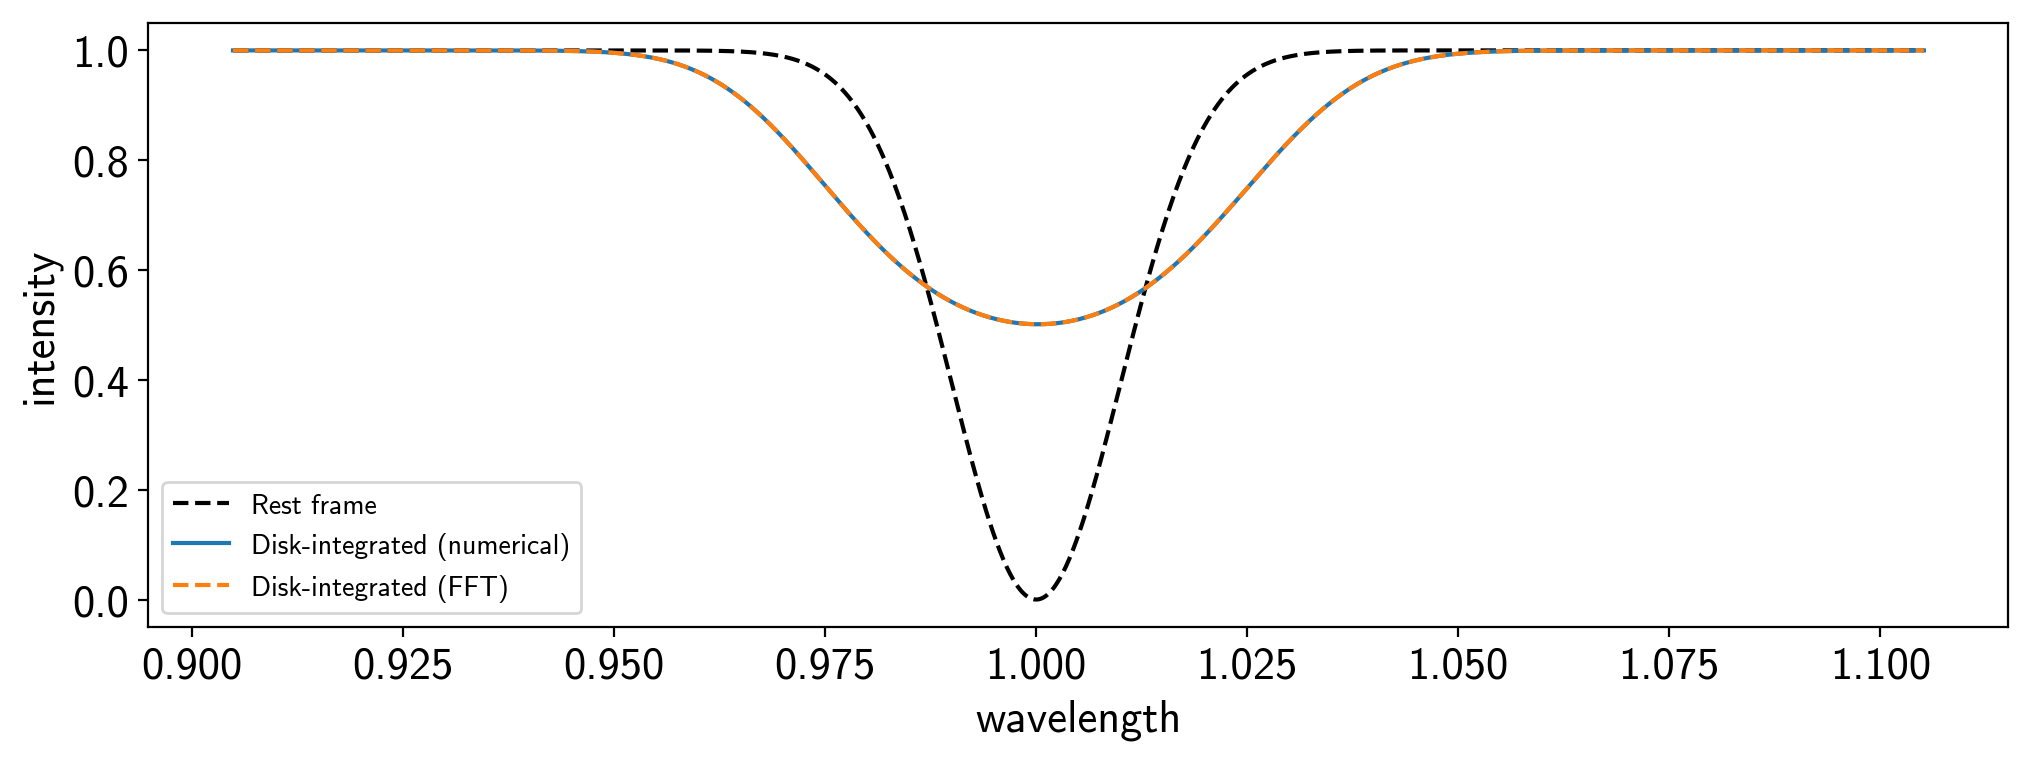

In [10]:
plt.plot(lam, S_num(xi, I0, alpha=0), 'k--', label="Rest frame");
plt.plot(lam, S_num(xi, I0, alpha=alpha), 'C0', label="Disk-integrated (numerical)");
plt.plot(lam, S(xi, I0, alpha=alpha), 'C1--', label="Disk-integrated (FFT)");
plt.legend(fontsize=10)
plt.xlabel("wavelength")
plt.ylabel("intensity");